# Chicago Ridership - Daily L Station Entries

Author: *Emre Okcular*

Date: 07.05.2021


## Table of Content:
1. [Introduction](#intro)

    1.1 [L Train and Lines](#ltrain)
    
    1.2 [Metro Map](#metro_map)    

    1.3 [Population Density Map](#pop_density)    
2. [Tasks and Questions](#questions)
3. [Dataset](#dataset)
4. [Feature Engineering](#feateng)

    4.1. [Splitting Date Features](#datef)
    
    4.2. [Holidays](#holidays)
5. [Exploratory Data Analysis](#eda)
6. [Characteristics of Data](#char)
7. [Findings](#findings)   
8. [Models for Forecasting Rides](#models)

    8.1. [Regressors](#reg)
    
      * [Linear Regression](#lr)   
      * [DecisionTreeRegressor](#dt)
      * [RandomForestRegressor](#rf)
      * [AdaBoostRegressor](#ab)
      * [GradientBoostingRegressor](#gb)
      
    8.2. [Time Series Models](#ts)    
    
      * [ARIMA](#arima)        
      * [SARIMA](#sarima)
      
    8.3. [Hyper Parameter Tuning and Cross Validation](#hp)    
    
9. [Model Evaluation](#model_eval)
10. [Final Model in Production](#final_model)
11. [Conclusion](#conc)
12. [Future Work](#future)
13. [Resources](#resources)

To run this notebook, firstly, you should run below cell and install all required packages from ```requirement.txt``` which is located in the same folder.

In [ ]:
! pip install -r requirements.txt

In [105]:
import pandas as pd # Dataframe operations
import numpy as  np # Numeric operations
import pandas_profiling # Generating htlm pages for EDA
import matplotlib.pyplot as plt # Visualization
from matplotlib_venn import venn2 # Visualization

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # US Holidays

from sklearn.tree               import DecisionTreeRegressor
from sklearn.compose            import *
from sklearn.ensemble           import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.impute             import *
from sklearn.linear_model       import LinearRegression
from sklearn.metrics            import accuracy_score, balanced_accuracy_score, f1_score, precision_score, average_precision_score , make_scorer, recall_score
from sklearn.pipeline           import Pipeline
from sklearn.preprocessing      import *
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import RandomizedSearchCV
from sklearn.model_selection    import cross_validate, KFold
from sklearn.metrics            import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn import set_config # For visualizing pipelines
set_config(display='diagram')

pd.options.mode.chained_assignment = None #  For catching data sclice copy error

 <a id='intro'></a>
### Introduction

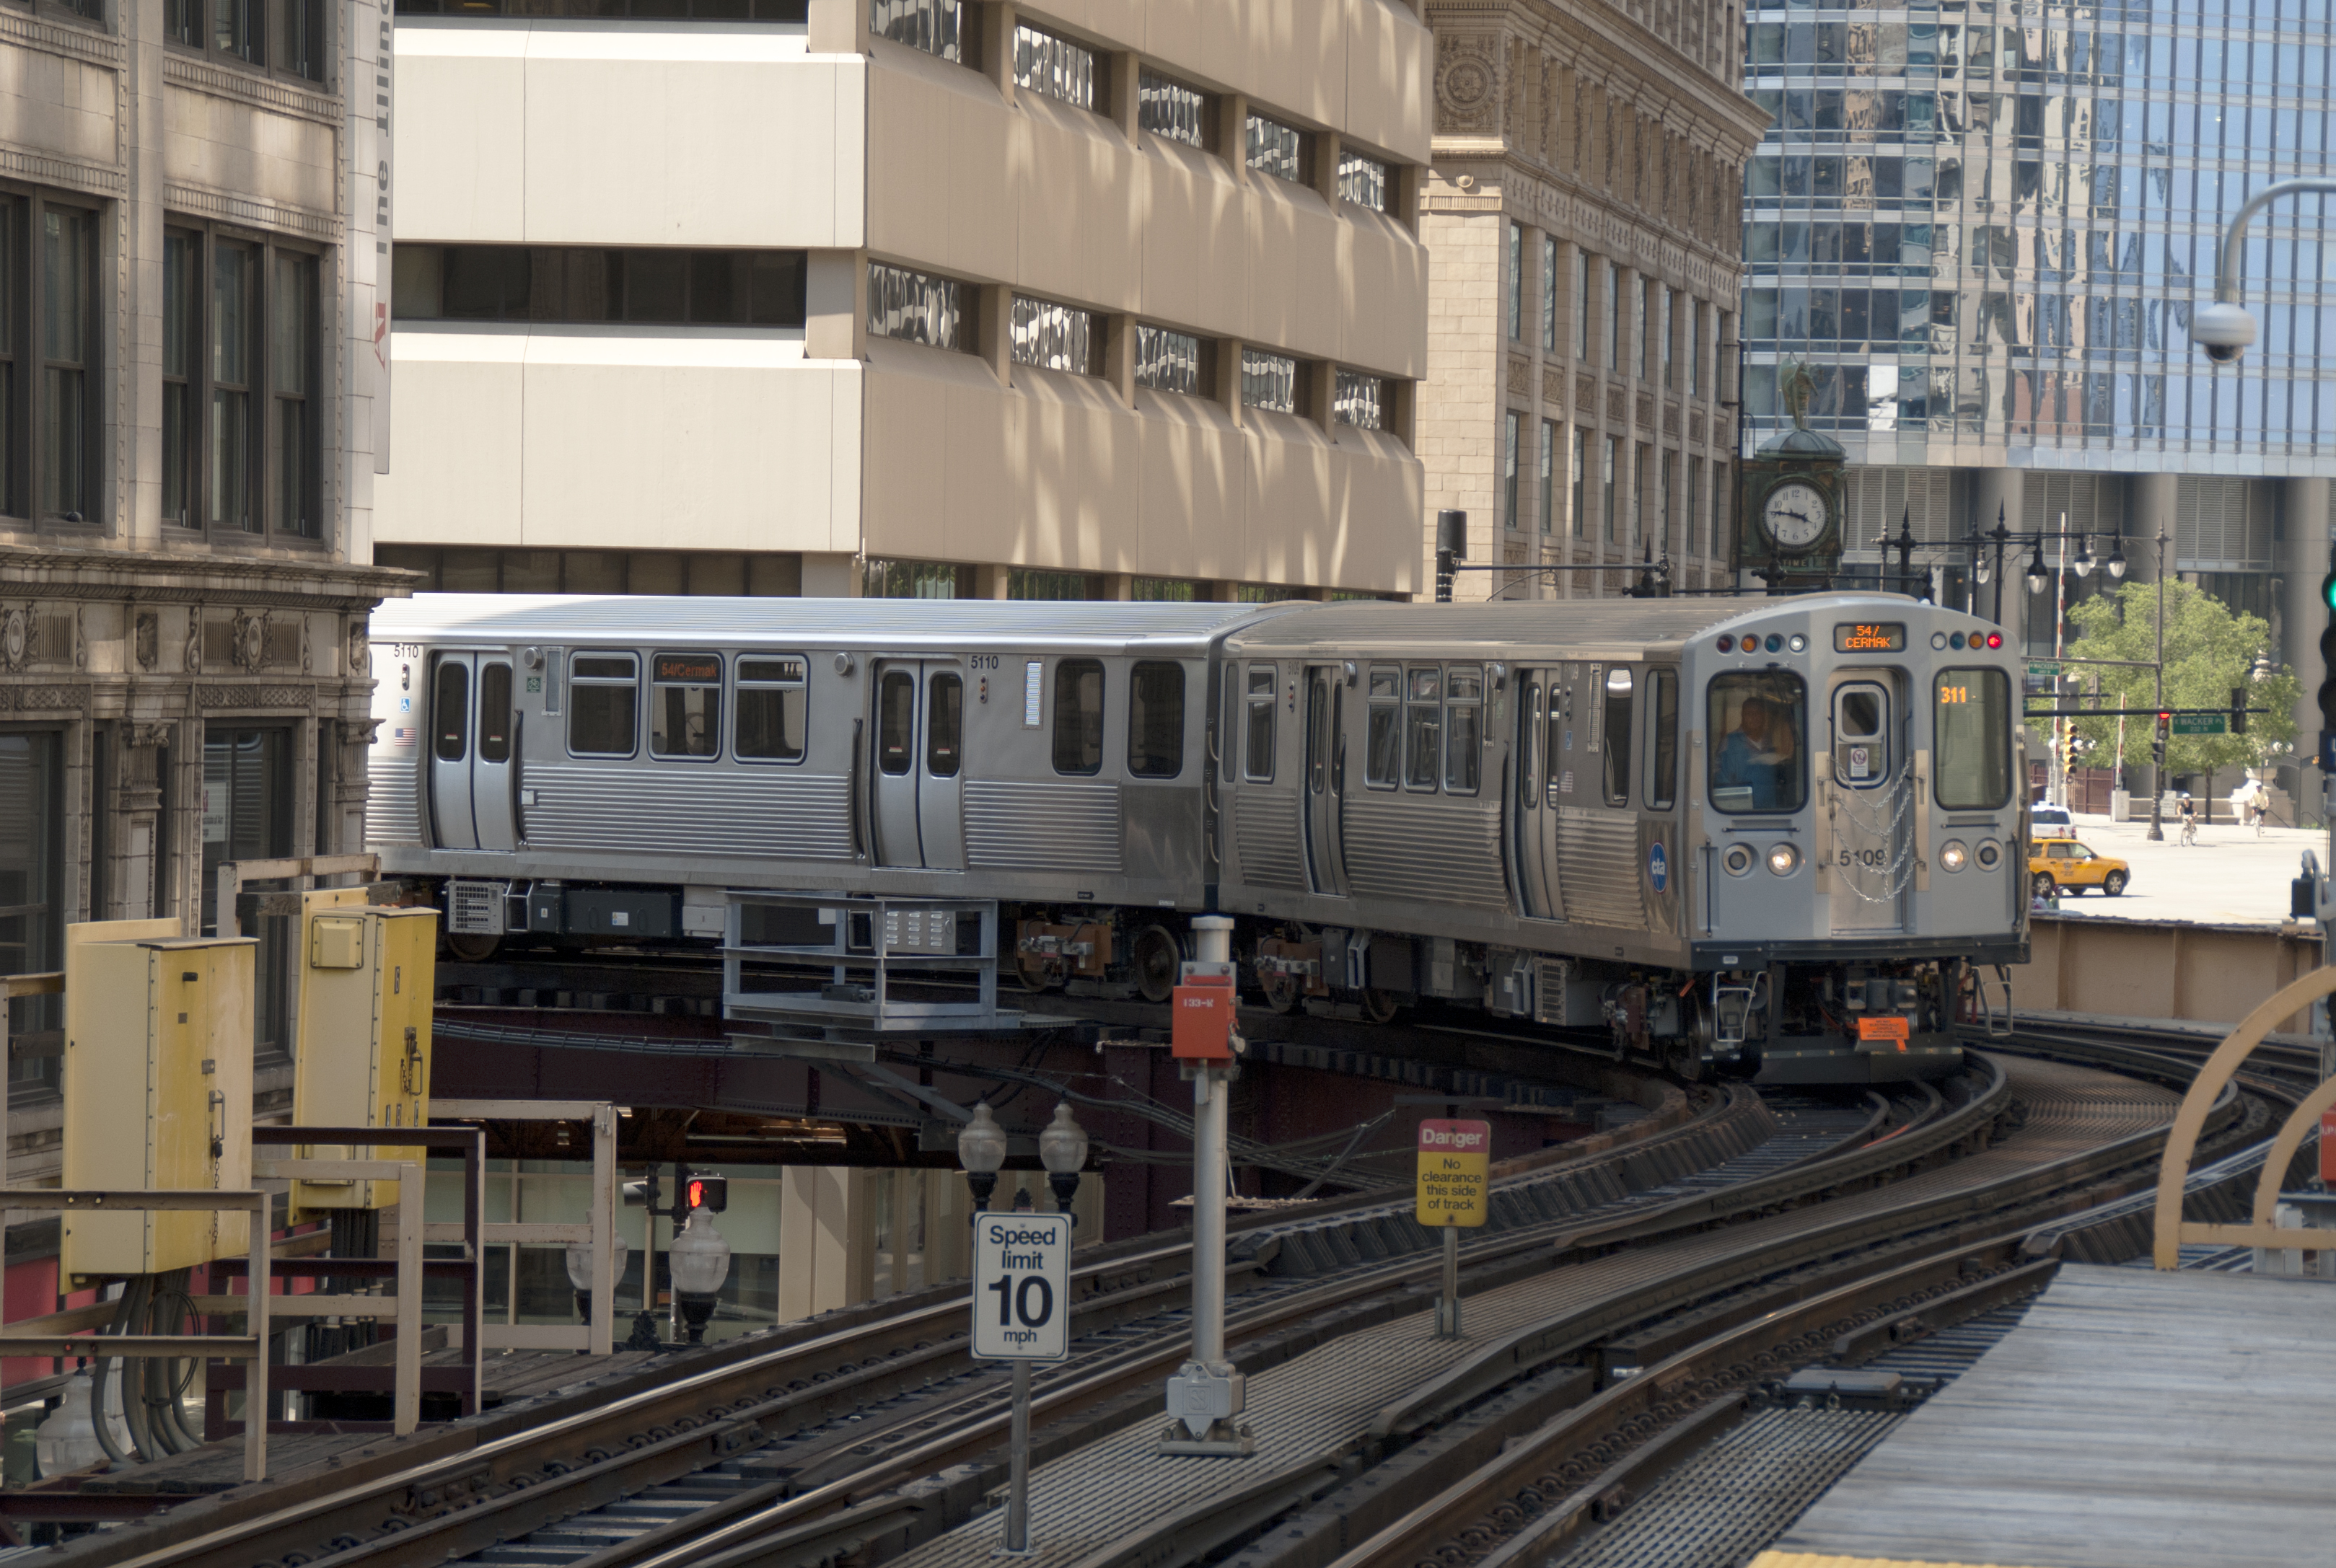

In [97]:
from IPython.display import Image
Image(filename="train.jpeg", width=600)

In this notebook, you can find the detailed analysis for **CTA - Ridership - 'L' Station Entries** dataset. EDA techniques applied for understanding the characteristics of the data and discover key findings. Various models were built for forecasting the daily rides for the transportation department to improve service in the next few years.

 <a id='ltrain'></a>
#### L Train and Lines

The Chicago "L" (short for "elevated") is the rapid transit system serving the city of Chicago and some of its surrounding suburbs in the U.S. state of Illinois. Operated by the Chicago Transit Authority (CTA), it is the fourth-largest rapid transit system in the United States in terms of total route length, at 102.8 miles (165.4 km) long as of 2014, and the third-busiest rail mass transit system in the United States, after the New York City Subway and the Washington Metro. In 2016, the "L" had 1,492 rail cars, eight different routes, and 145 train stations; average weekday ridership was 759,866.

The "L" provides 24-hour service on the Red and Blue Lines and is one of only five rapid transit systems in the United States to do so. The oldest sections of the "L" started operations in 1892, making it the second-oldest rapid transit system in the Americas, after New York City's elevated lines.

The "L" gained its name because large parts of the system run on elevated track. However, portions of the network are also in subway tunnels, at grade level, or in open cuts.

Eight 'L' train lines cross the city providing rapid transit services (known as a "subway" or "metro" system in many cities). 140 local and express bus routes complement this system. Many routes run from early morning through late evening, year-round, and a number run 24/7. Trains serve over 140 stations located throughout the city and nearby suburbs, on elevated railways, in subways, or on the ground.

|                    | General Informations            |
|--------------------|---------------------------------|
| Number of stations | 145                             |
| Daily ridership    | 728,643 (average weekday, 2018) |
| Annual ridership   | 226.08 million (2018)           |
| Operator(s)        | Chicago Transit Authority       |
| System length      | 102.8 mi (165.4 km)             |
| Top speed          | 55 mph (89 km/h)                |

* **Blue Line**, consisting of the O'Hare, Milwaukee-Dearborn Subway, and Congress branches
The Blue Line extends from O'Hare International Airport through the Loop via the Milwaukee-Dearborn subway to the West Side. Trains travel to Des Plaines Avenue in Forest Park via the Eisenhower Expressway median. The route from O'Hare to Forest Park is 26.93 miles (43 km) long. The number of stations is 33. The Blue Line is the second-busiest, with 176,120 weekday boardings. It operates 24 hours a day, 7 days a week.
* **Brown Line** or Ravenswood Line
The Brown Line follows an 11.4-mile (18 km) route, between the Kimball terminal in Albany Park and the Loop in downtown Chicago. In 2013, the Brown Line had an average weekday ridership of 108,529.
* **Green Line**, consisting of the Lake Street Elevated, South Side Main Line, and Ashland and East 63rd branches
the Green Line extends 20.8 miles (33.5 km) with 30 stops between Forest Park and Oak Park (Harlem/Lake), through The Loop, to the South Side. The average number of weekday boardings in 2013 was 68,230.
* **Orange Line** or Midway Line
The 13-mile (21 km) long Orange Line was constructed from 1987 until 1993 on existing railroad embankments and new concrete and steel elevated structure. It runs from a station adjacent to Midway International Airport on the Southwest Side to The Loop in downtown Chicago. Average weekday ridership in 2013 was 58,765.
* **Pink Line** consisting of the Cermak Branch and Paulina Connector
The Pink Line is an 11.2-mile (18 km) rerouting of former Blue Line branch trains from 54th/Cermak in Cicero via the previously non-revenue Paulina Connector and the Green Line on Lake Street to the Loop. Its average weekday ridership in 2013 was 31,572.
* **Purple Line**, consisting of the Evanston Shuttle and Evanston Express
The Purple Line is a 3.9-mile (6 km) branch serving north suburban Evanston and Wilmette with express service to the Loop during weekday rush hours. 2013 average weekday ridership was 42,673 passenger boardings.
* **Red Line**, consisting of the North Side Main Line, State Street subway, and Dan Ryan Branch
The Red Line is the busiest route, with 234,232 passenger boardings on an average weekday in 2013.[34] It includes 33 stations on its 26-mile (42 km) route, traveling from the Howard terminal on the city's north side, through downtown Chicago via the State Street subway, then down the Dan Ryan Expressway median to 95th/Dan Ryan on the South Side. Despite its length, the Red Line stops 5 miles (8.0 km) short of the city's southern border.
* **Yellow Line**, or Skokie Swift
The Yellow Line is a 4.7-mile (8 km) three station line that runs from the Howard Street terminal to Skokie terminal in north suburban Skokie. The Yellow Line is the only "L" route that does not provide direct service to the Loop. The Yellow Line previously operated as a nonstop shuttle, until the downtown Skokie station Oakton–Skokie opened on April 30, 2012. Its average weekday ridership in 2013 was 6,338 passenger boardings.
* **The Loop**
Brown, Green, Orange, Pink, and Purple Line Express trains serve downtown Chicago via the Loop elevated. The Loop's eight stations average 72,843 weekday boardings. The Orange Line, Purple Line and the Pink Line run clockwise, the Brown Line runs counter-clockwise. The Green Line is the Loop's only through service; the other four lines circle the Loop and return to their starting points. The loop crossing at Lake and Wells has been described in the Guinness Book of World Records as the world's busiest railroad crossing.


Data represents the real-world information. To look more closely with this perspective we need to understand about the context as much as we can. Below, you can see the System Map for L Trains. There are 8 different lines with stations. All the sation names in the dataset are coming from this map. Finally, rides can vary from city center to suburbans because of different population density.

<a id='metro_map'></a>
#### Metro Map

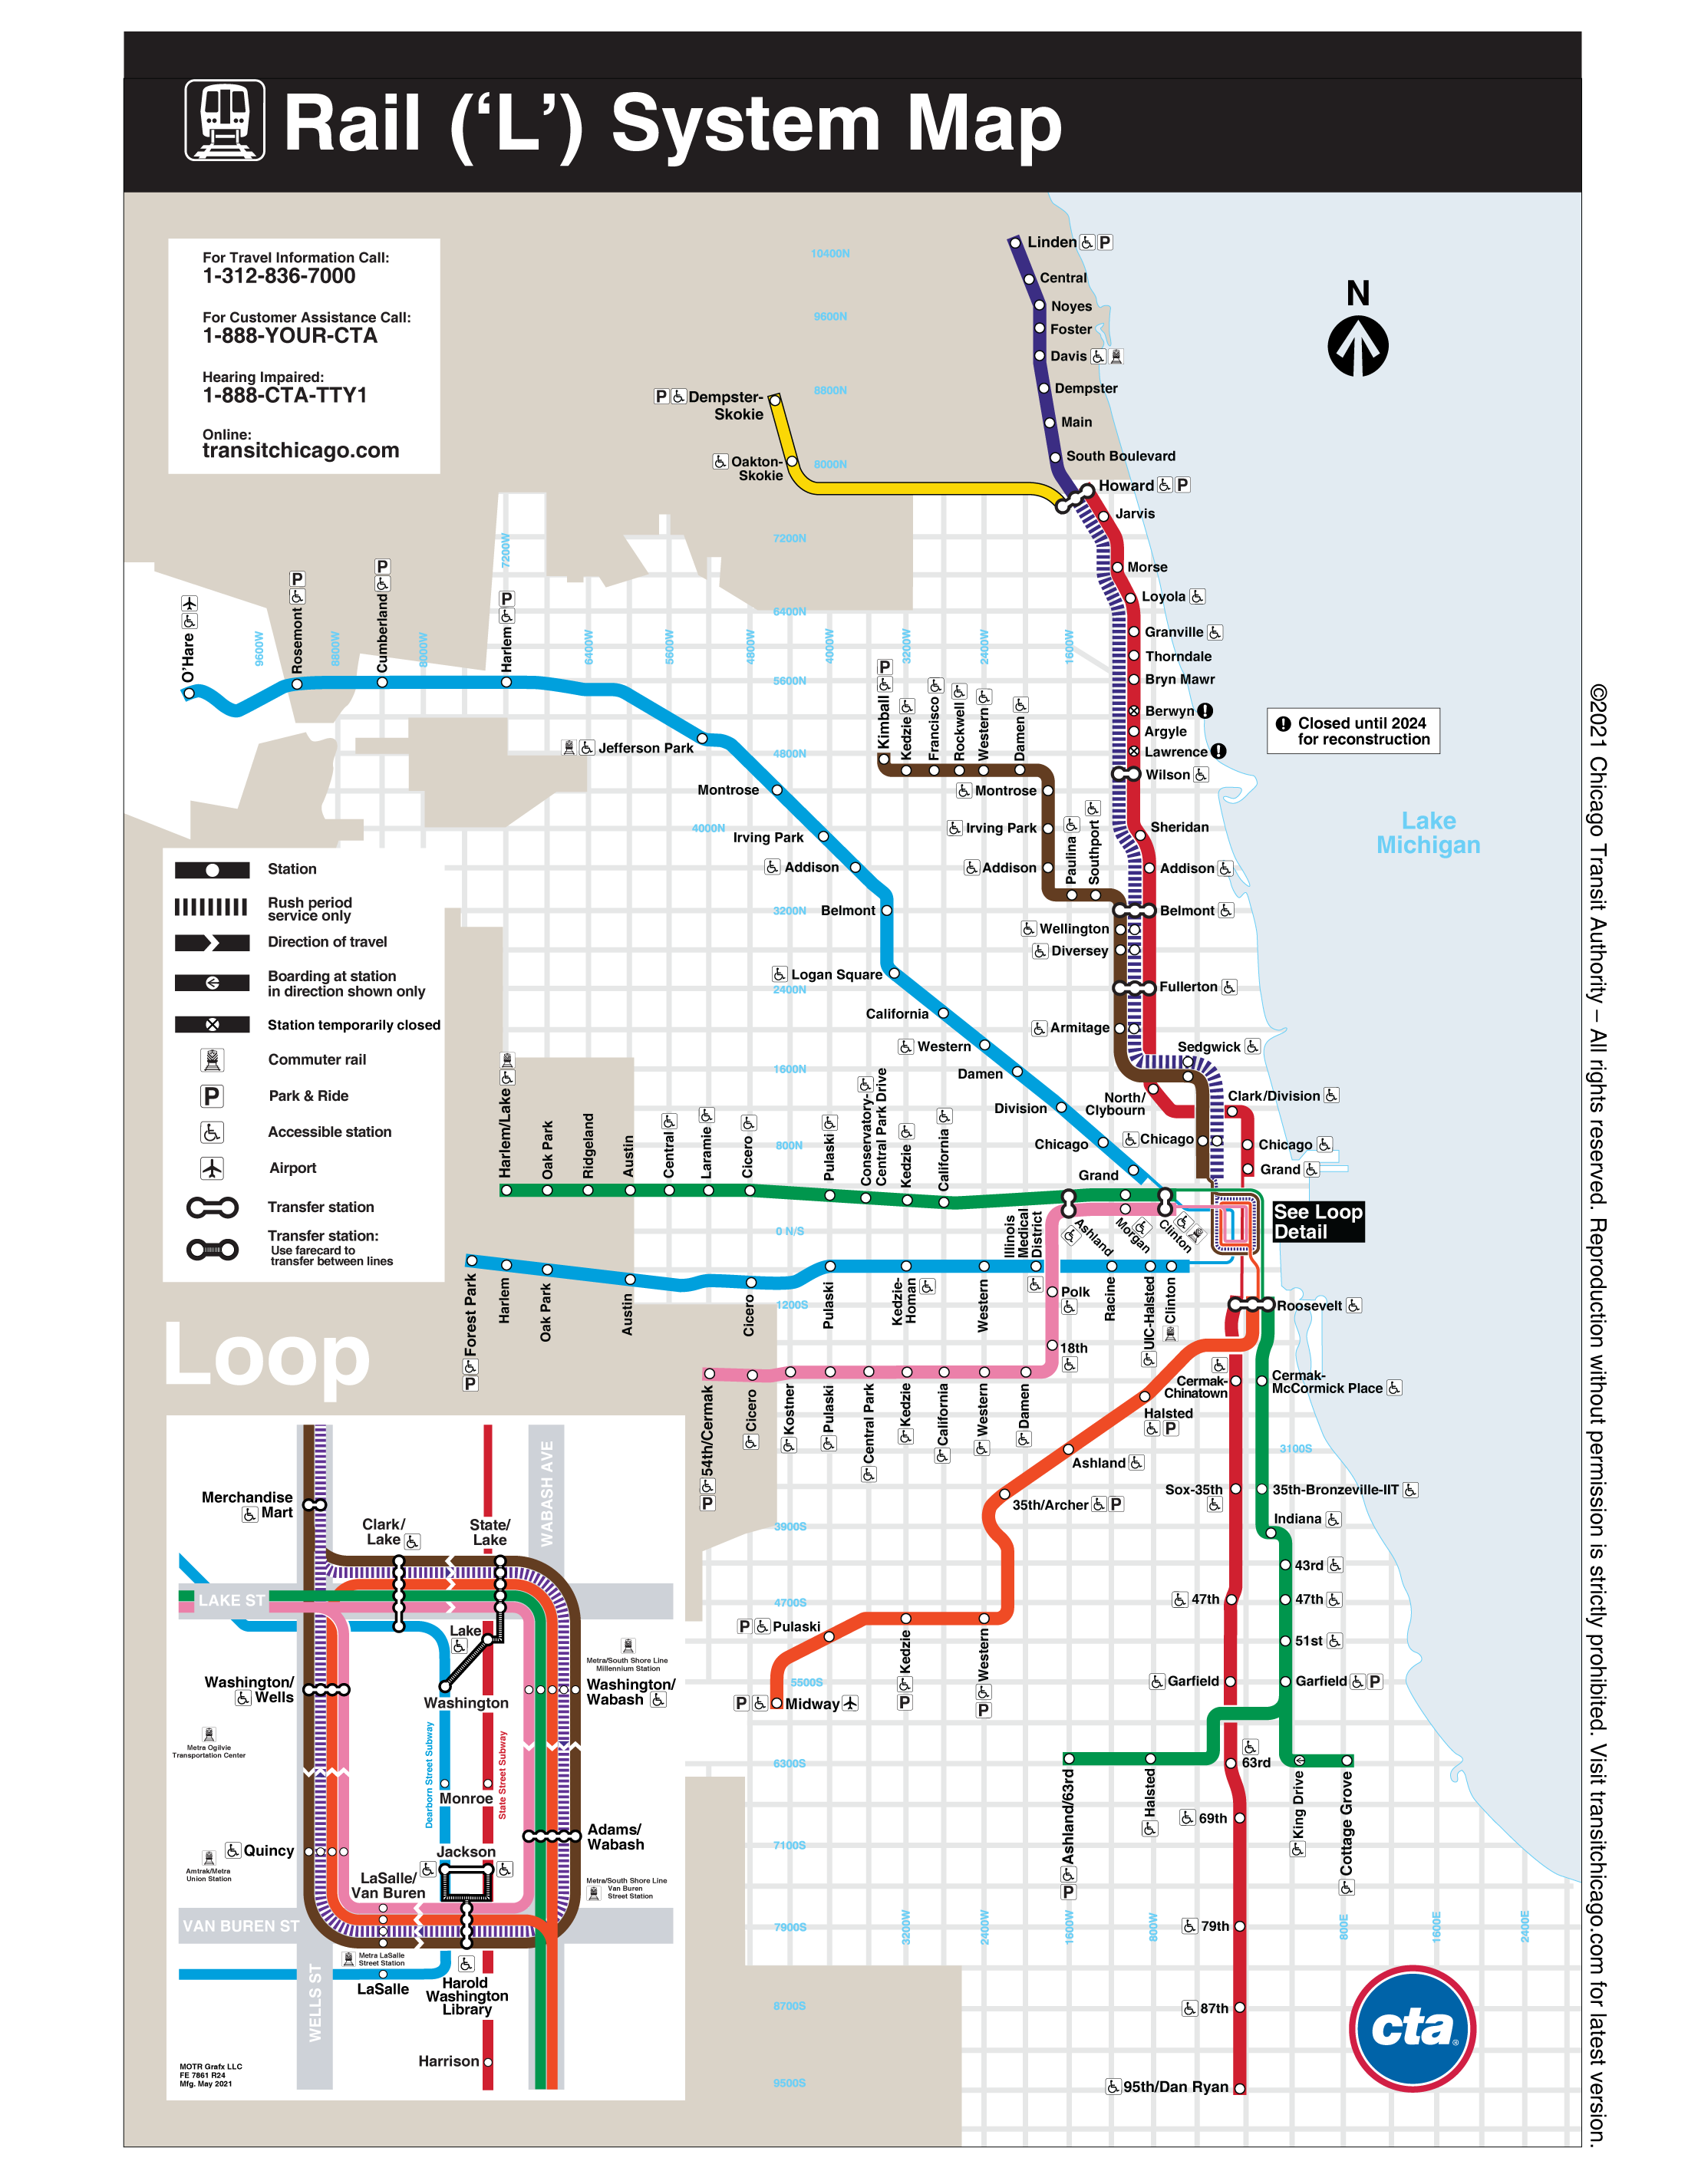

In [28]:
from IPython.display import Image
Image(filename="l_map.png", width=1000)

As I mentioned below, the one of the reason which is directly related with rides can be population density. In the readme file, rides are only for first turnstile pass. This means all of these numbers are using the public transportation system first time. Lets take a look at population density of Chicago.

 <a id='pop_density'></a>
#### Population Density Map of Chicago in 2016

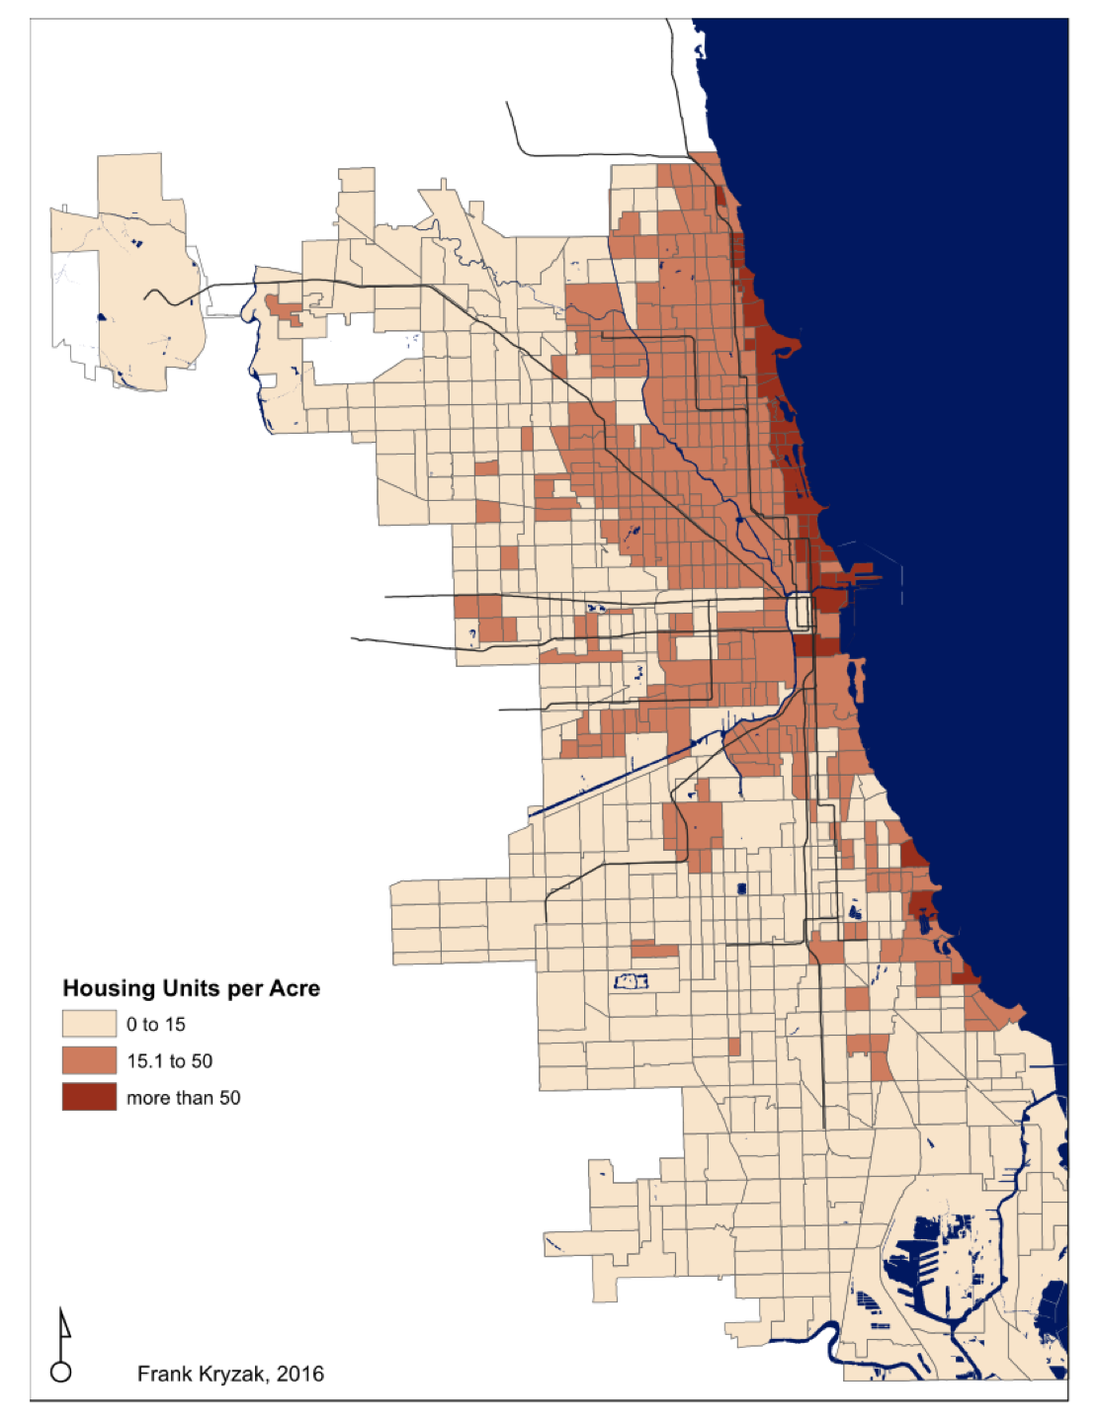

In [99]:
from IPython.display import Image
Image(filename="population_density.png", width=600)

We can see that gray lines are train lines. The red and brown lines are going with north direction which has the highest population density. It is fair to expect that Red line is he most bussiest line.

<a id='questions'></a>
### Tasks and Questions

In this work, below questions will be answered.

- [X] Load data and perform exploratory data analysis.

- [ ] What are the characteristics of the data?

- [ ] What are your findings?

- [ ] What did you learn from the data?

- [ ] The transportation department wants to improve service in the next few years. Can you build a model for them to forecast daily rides? (Please use 2017 data as testing set for evaluation) Which aspects should you consider for this model? Please explain how you built the model and justify the choices you made.

- [ ] How would you evaluate this model to ensure it would be robust for production usage?

<a id='dataset'></a>
### Dataset

You can download the dataset [CTA - Ridership - 'L' Station Entries - Daily Totals | City of Chicago | Data Portal](https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f)

The dataset shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. You can see daily entries at all turnstiles, combined, for each station. You can file the downloaded dataset in the same folder as ```CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv```

The raw data will be filtered between 2002 and 2016. 2017 and the rest will be used for testing. 

| Columns     | Type | Description                                                                                                                                                                                                                                                                                                                                          |
|-------------|------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| station_id  | int  | Unique IDs for each station                                                                                                                                                                                                                                                                                                                          |
| stationname | str  | On the rail system, a customer is counted as an "entry" each time he or she passes through a turnstile to enter a station.  Customers are not counted as "entries" when they make a "cross-platform" transfer from one rail line to another, since they  don't pass through a turnstile.                                                             |
| date        | date | YYYY-MM-DD                                                                                                                                                                                                                                                                                                                                           |
| daytype     | str  | Daytype fields in the data are coded as "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays.  Note that New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving, and Christmas Day are considered  as "Sundays" for the purposes of ridership reporting.  All other holidays are reported as the type of day they fall on. |
| rides       | int  | Number of rides                                                                                                                                                                                                                                                                                                                                      |



  Daytypes and descriptions are as follows: 

See ```ridershipreadme.txt``` file for information on how these numbers are calculated.

Below you can find **[ridershipreadme.txt](https://data.cityofchicago.org/api/assets/CCAFA078-D8FC-43EE-8FAA-28007103DA2E?download=true)** file.

```
Ridership Readme 
12-Aug-2011
Chicago Transit Authority

* About CTA ridership numbers *
Ridership statistics are provided on a system-wide and bus route/station-level basis. Ridership is primarily counted as boardings, that is, customers boarding a transit vehicle (bus or rail).  On the rail system, there is a distinction between station entries and total rides, or boardings. Datasets indicate such in their file name and description.

* How people are counted on the 'L' *
On the rail system, a customer is counted as an "entry" each time he or she passes through a turnstile to enter a station.  Customers are not counted as "entries" when they make a "cross-platform" transfer from one rail line to another, since they don't pass through a turnstile. Where the number given for rail is in "boardings," what's presented is a statistically valid estimate of the actual number of boardings onto the rail system. 

* How people are counted on buses *
Boardings are recorded using the bus farebox and farecard reader. In the uncommon situation when there is an operating error with the farebox and the onboard systems cannot determine on which route a given trip's boardings should be allocated, these boardings are tallied as Route 0 in some reports.  Route 1001 are shuttle buses used for construction or other unforeseen events.

* "Daytype" *
Daytype fields in the data are coded as "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays.  Note that New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving, and Christmas Day are considered as "Sundays" for the purposes of ridership reporting.  All other holidays are reported as the type of day they fall on.
```


**Loading Dataset**

In [3]:
df = pd.read_csv("CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv", parse_dates=["date"])

[Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) package is a useful EDA tool. It generates profile reports from Pandas DataFrames. 

In [4]:
# The profiling report can also be exported into an interactive HTML file with the following code.
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="Chicago Ridership Data Profiling.html")

In [33]:
pandas_profiling.ProfileReport(df)

You can find the report in ```Chicago Ridership Data Profiling.html``` file.

In [5]:
df.shape

(1049633, 5)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779792 entries, 12509 to 1028039
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   station_id   779792 non-null  int64         
 1   stationname  779792 non-null  object        
 2   date         779792 non-null  datetime64[ns]
 3   daytype      779792 non-null  object        
 4   rides        779792 non-null  int64         
 5   year         779792 non-null  int64         
 6   month        779792 non-null  int64         
 7   day          779792 non-null  int64         
 8   holiday      779792 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 59.5+ MB


In [102]:
df.head()

station_id stationname       date daytype  rides  year  month  day  \
12509       40340      Berwyn 2009-05-21       W   3287  2009      5   21   
13185       40870   Francisco 2006-09-21       W      0  2006      9   21   
13501       40360   Southport 2007-08-25       A      0  2007      8   25   
14323       40140      Skokie 2003-02-01       A      0  2003      2    1   
18337       41270        43rd 2005-05-08       U    270  2005      5    8   

       holiday  
12509        0  
13185        0  
13501        0  
14323        0  
18337        0

In [103]:
df.describe()

station_id          rides           year          month  \
count  779792.000000  779792.000000  779792.000000  779792.000000   
mean    40760.339193    3310.417699    2009.017995       6.522362   
std       445.026697    3177.240067       4.328207       3.448098   
min     40010.000000       0.000000    2002.000000       1.000000   
25%     40370.000000    1128.000000    2005.000000       4.000000   
50%     40750.000000    2329.000000    2009.000000       7.000000   
75%     41150.000000    4358.000000    2013.000000      10.000000   
max     41690.000000   36323.000000    2017.000000      12.000000   

                 day        holiday  
count  779792.000000  779792.000000  
mean       15.725572       0.027373  
std         8.802421       0.163167  
min         1.000000       0.000000  
25%         8.000000       0.000000  
50%        16.000000       0.000000  
75%        23.000000       0.000000  
max        31.000000       1.000000

### Feature Engineering

#### Splitting Date Features

Since we have date column, we can split this information as year, month and day. This will help us to have numeric features in modeling part.

In [9]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

#### Holidays

For using the holiday information new column is created with US Federal Holidays.

In [10]:
dr = pd.date_range(start='2001-01-01', end='2021-02-28')
df_holiday_range = pd.DataFrame()
df_holiday_range['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

In [11]:
df['holiday'] = df['date'].isin(holidays)

Furthermore, we already had holiday information with daytype = U. Therefore, we can check if there are any overlapped holiday. For example, we can see from below visualization that there are 12250 holidays which are not labeled with U daytype. This means CTA identified some holidays as normal days. To be precise, we will keep holiday feature for our modeling part.

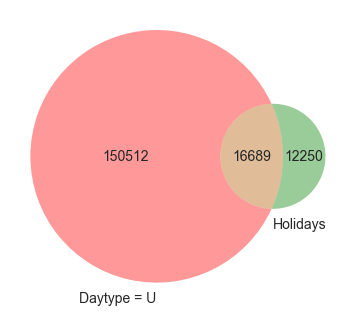

In [12]:
A = np.array(df.daytype=="U")
B = np.array(df.holiday)

only_a = sum(A & ~B)
only_b = sum(B & ~A)
a_and_b = sum(A & B)

v = venn2(subsets = (only_a, only_b, a_and_b), set_labels = ('Daytype = U', 'Holidays'))
for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(14)

In [13]:
df.head()

station_id       stationname       date daytype  rides  year  month  day  \
0       41280    Jefferson Park 2017-12-22       W   6104  2017     12   22   
1       41000  Cermak-Chinatown 2017-12-18       W   3636  2017     12   18   
2       40280      Central-Lake 2017-12-02       A   1270  2017     12    2   
3       40140   Dempster-Skokie 2017-12-19       W   1759  2017     12   19   
4       40690          Dempster 2017-12-03       U    499  2017     12    3   

   holiday  
0    False  
1    False  
2    False  
3    False  
4    False

Lets take a closer look at the holidays that has not U daytype. 

In [114]:
sorted((df[(B & ~A)==True].date).unique())

[numpy.datetime64('2006-01-16T00:00:00.000000000'),
 numpy.datetime64('2006-02-20T00:00:00.000000000'),
 numpy.datetime64('2006-10-09T00:00:00.000000000'),
 numpy.datetime64('2006-11-10T00:00:00.000000000'),
 numpy.datetime64('2007-01-15T00:00:00.000000000'),
 numpy.datetime64('2007-02-19T00:00:00.000000000'),
 numpy.datetime64('2007-10-08T00:00:00.000000000'),
 numpy.datetime64('2007-11-12T00:00:00.000000000'),
 numpy.datetime64('2008-01-21T00:00:00.000000000'),
 numpy.datetime64('2008-02-18T00:00:00.000000000'),
 numpy.datetime64('2008-10-13T00:00:00.000000000'),
 numpy.datetime64('2008-11-11T00:00:00.000000000'),
 numpy.datetime64('2009-01-19T00:00:00.000000000'),
 numpy.datetime64('2009-02-16T00:00:00.000000000'),
 numpy.datetime64('2009-10-12T00:00:00.000000000'),
 numpy.datetime64('2009-11-11T00:00:00.000000000'),
 numpy.datetime64('2010-01-18T00:00:00.000000000'),
 numpy.datetime64('2010-02-15T00:00:00.000000000'),
 numpy.datetime64('2010-10-11T00:00:00.000000000'),
 numpy.datet

For example Presidents day (third Monday in February) and Veterans Day (November 11th) is not considered as holiday in the raw dataset.

In [14]:
df["holiday"] = df["holiday"].astype(int) # Convert True/False to 1/0

In [15]:
df.isnull().sum()

station_id     0
stationname    0
date           0
daytype        0
rides          0
year           0
month          0
day            0
holiday        0
dtype: int64

There are no null values in the dataset, I will also check if there are any other value which might represent null values such as 0, "unknown", "None" etc

<a id='eda'></a>
### Exploratory Data Analysis

In [179]:
df_grouped_by_station = df[df["rides"]==0].groupby(["stationname"],as_index=True).count()["rides"]

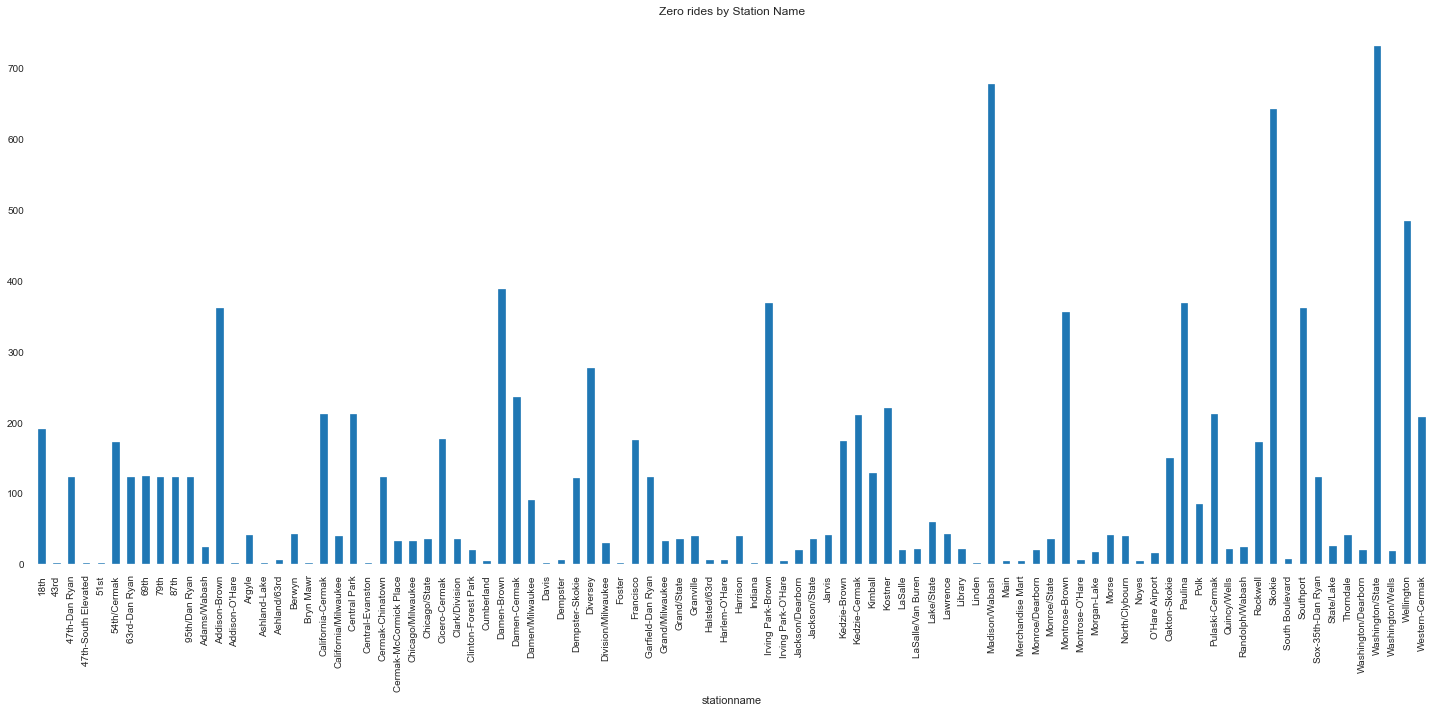

In [181]:
df_grouped_by_station.plot(kind="bar",title="Zero rides by Station Name",figsize=(25,10))
plt.show()

In [210]:
df_Skokie = df[(df["stationname"]=="Skokie") & (df["year"]==2002) & (df["month"]==1)]

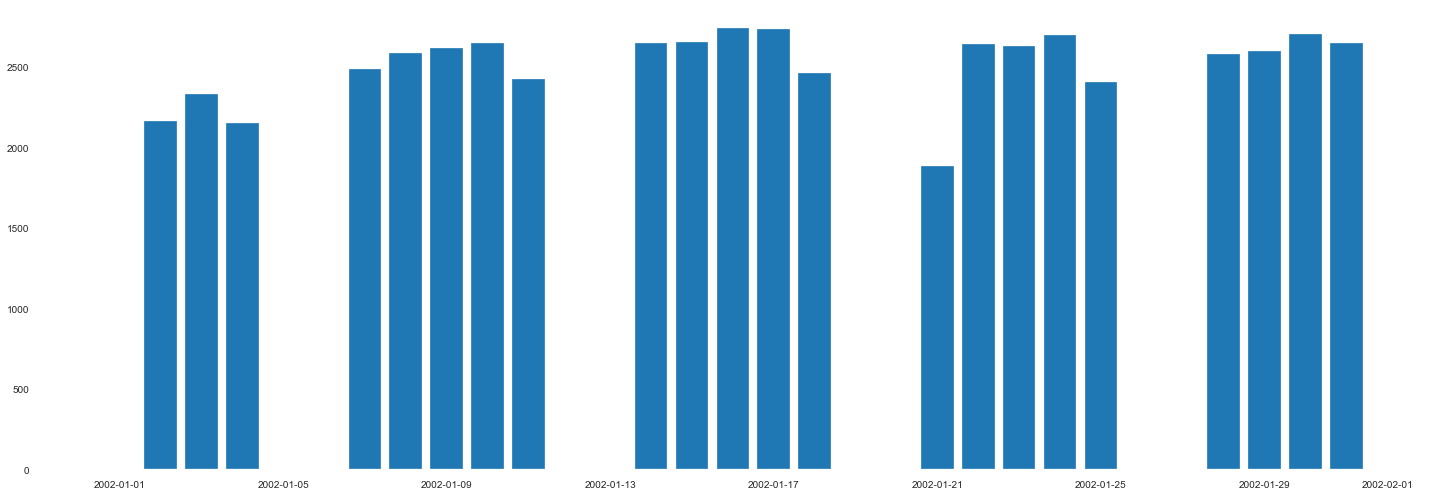

In [211]:
fig, ax = plt.subplots(1,1,figsize=(20,7))

ax.bar(df_Skokie["date"],df_Skokie["rides"])
fig.tight_layout()
plt.show()

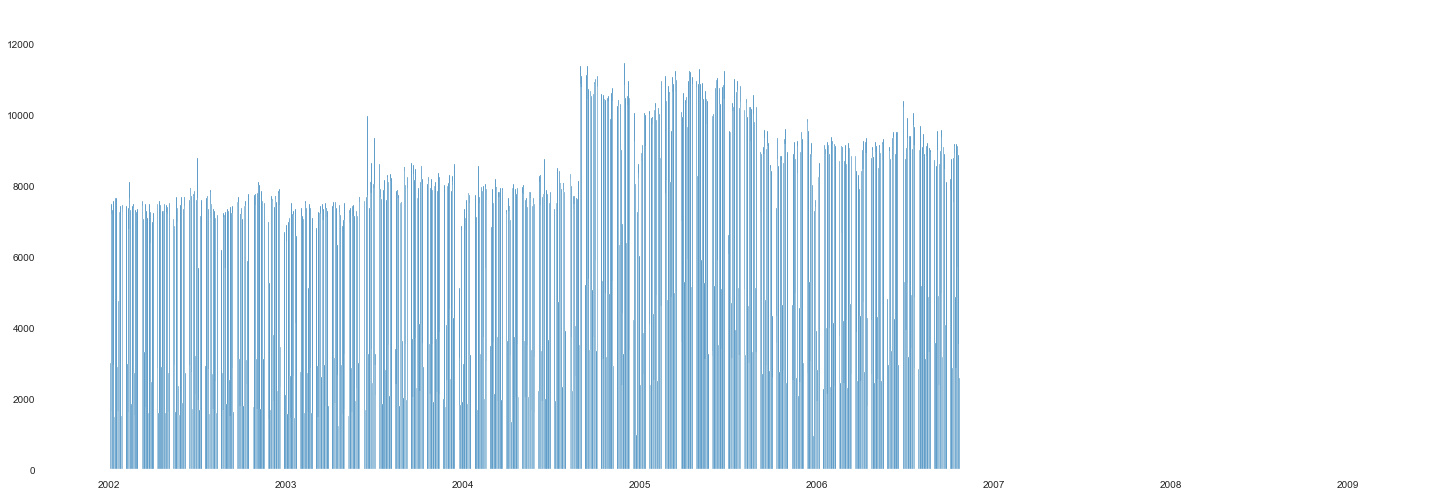

In [193]:
df_ws = df[df["stationname"]=="Washington/State"]
fig, ax = plt.subplots(1,1,figsize=(20,7))

ax.bar(df_ws["date"],df_ws["rides"])
fig.tight_layout()
plt.show()

In [162]:
df_grouped_by_year = df[df["rides"]==0].groupby(["year"],as_index=True).count()["rides"]

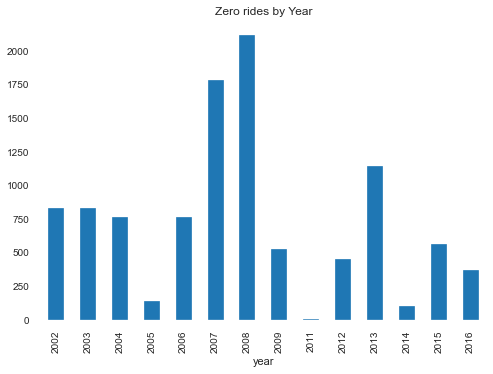

In [173]:
df_grouped_by_year.plot(kind="bar",title="Zero rides by Year")
plt.show()

In [174]:
df_2007 = df[df.year == 2007]
df_2007 = df_2007[df_2007["rides"]==0].groupby(["stationname"],as_index=True).count()["rides"]

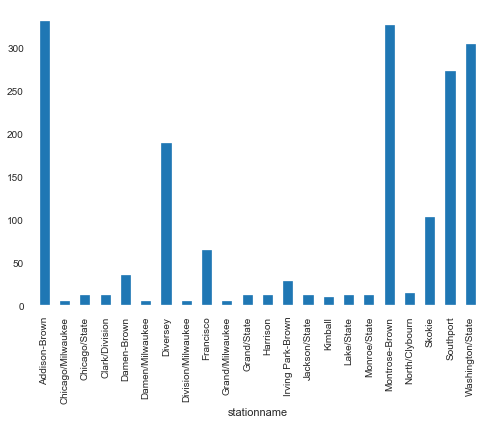

In [175]:
df_2007.plot(kind="bar")

In [176]:
df_2008 = df[df.year == 2008]
df_2008 = df_2008[df_2008["rides"]==0].groupby(["stationname"],as_index=True).count()["rides"]

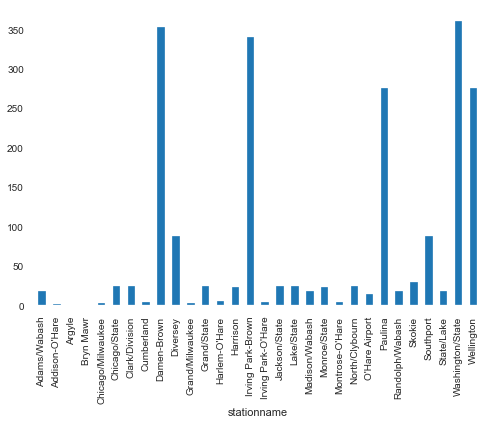

In [177]:
df_2008.plot(kind="bar")

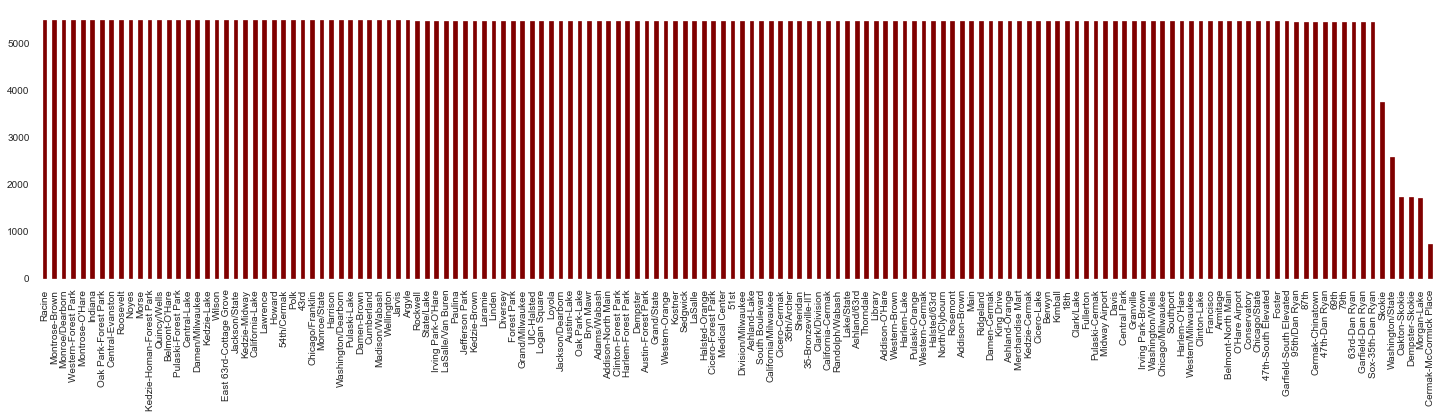

In [212]:
df["stationname"].value_counts().plot(kind='bar',figsize=(25,5), color="maroon")
plt.xticks(rotation=90)
plt.show()

In [125]:
df[df.stationname == "Oakton-Skokie"].sort_values("date")

station_id    stationname       date daytype  rides  holiday
996239        41680  Oakton-Skokie 2012-04-01       U      0    False
218887        41680  Oakton-Skokie 2012-04-02       W      0    False
878895        41680  Oakton-Skokie 2012-04-03       W      0    False
667041        41680  Oakton-Skokie 2012-04-04       W      0    False
621659        41680  Oakton-Skokie 2012-04-05       W      0    False
...             ...            ...        ...     ...    ...      ...
537623        41680  Oakton-Skokie 2015-12-28       W    519    False
336254        41680  Oakton-Skokie 2015-12-29       W    605    False
603511        41680  Oakton-Skokie 2015-12-30       W    587    False
782553        41680  Oakton-Skokie 2015-12-31       W    597    False
1020924       41680  Oakton-Skokie 2016-01-01       U    173     True

[1371 rows x 6 columns]

In [64]:
df["stationname"].value_counts()[-10:]

79th                      5086
63rd-Dan Ryan             5084
Garfield-Dan Ryan         5084
Sox-35th-Dan Ryan         5084
Skokie                    3746
Washington/State          2588
Oakton-Skokie             1371
Dempster-Skokie           1371
Morgan-Lake               1341
Cermak-McCormick Place     366
Name: stationname, dtype: int64

Some station names are new.

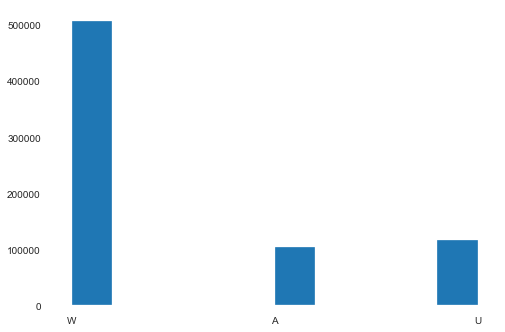

In [67]:
df["daytype"].hist(grid=False)

In [118]:
df.stationname.unique()

array(['Berwyn', 'Francisco', 'Southport', 'Skokie', '43rd', 'Racine',
       'Morse', 'Noyes', 'Wilson', 'Ridgeland', 'LaSalle', 'Wellington',
       'Fullerton', 'Davis', 'Bryn Mawr', 'Laramie', "Irving Park-O'Hare",
       "O'Hare Airport", "Addison-O'Hare", 'Cicero-Lake',
       'South Boulevard', '47th-South Elevated', 'Damen/Milwaukee',
       'Monroe/State', '47th-Dan Ryan', 'Kostner', 'Polk',
       'Pulaski-Forest Park', '95th/Dan Ryan', 'Addison-North Main',
       '54th/Cermak', 'Western-Forest Park', 'Kimball', 'Forest Park',
       'Garfield-South Elevated', "Belmont-O'Hare", 'Ashland-Lake',
       'Diversey', 'Conservatory', 'Foster', 'Pulaski-Cermak',
       'Cicero-Forest Park', 'Western-Brown', '35th/Archer',
       'Oakton-Skokie', 'Western-Cermak', 'Cumberland', 'Oak Park-Lake',
       'Kedzie-Cermak', 'Pulaski-Lake', 'Ashland/63rd', 'Montrose-Brown',
       '79th', 'Rockwell', 'Thorndale', 'Argyle', 'Central-Lake',
       'California/Milwaukee', 'Washington/Dearborn

In [69]:
df.sort_values("date")

station_id        stationname       date daytype  rides
245369        40600            Kostner 2002-01-01       U      0
1000113       40740     Western-Cermak 2002-01-01       U      0
189816        40730   Washington/Wells 2002-01-01       U    209
539893        40120        35th/Archer 2002-01-01       U    228
292183        40350        UIC-Halsted 2002-01-01       U    393
...             ...                ...        ...     ...    ...
733036        41160       Clinton-Lake 2016-01-01       U    764
693135        40190  Sox-35th-Dan Ryan 2016-01-01       U   2104
723633        40040       Quincy/Wells 2016-01-01       U   1225
987654        41450      Chicago/State 2016-01-01       U  10781
847465        40200    Randolph/Wabash 2016-01-01       U   3269

[727088 rows x 5 columns]

In [127]:
df[df.rides==0].groupby()

station_id       stationname       date daytype  rides  holiday
13185         40870         Francisco 2006-09-21       W      0    False
13501         40360         Southport 2007-08-25       A      0    False
14323         40140            Skokie 2003-02-01       A      0    False
148610        40500  Washington/State 2006-10-26       W      0    False
148653        40990              69th 2013-08-05       W      0    False
...             ...               ...        ...     ...    ...      ...
1027503       40210      Damen-Cermak 2003-04-13       U      0    False
1027510       41230     47th-Dan Ryan 2013-10-05       A      0    False
1027555       40330       Grand/State 2007-11-04       U      0    False
1027616       41440     Addison-Brown 2007-02-24       A      0    False
1028023       41200            Argyle 2012-09-25       W      0    False

[10028 rows x 6 columns]

<a id='findings'></a>
### Findings

First entries, boarding to the rail system.

Holidays are different

some new stations




### Models for Forecasting Daily Rides

**Train-Test Split Method**

In [16]:
print("Minimum date : ",df.date.min(), "\nMaximium date : ",df.date.max())

Minimum date :  2001-01-01 00:00:00 
Maximium date :  2021-02-28 00:00:00


Lets filter the data between 2002 and 2016. 2017 and the rest will be used for testing.

In [17]:
df = df[df.date.between("2002-01-01 00:00:00", "2017-01-01 00:00:00")]
df_test = df[df.date.between("2017-01-01 00:00:00", "2021-02-28 00:00:00")]

Since train-test split method is given in question, the dataset will be splitted with end of 2016. In addition, if the train test method is not given ```TimeSeriesSplit``` can be used because shuffling with classic method is not appropriate for time series.

In [107]:
X_train = df.drop(["rides","date","stationname"],axis=1) # Date and station name also removed because we splitted date information into 3 columns. Also we will use StationID instead of station names.
X_test = df_test.drop(["rides","date","stationname"],axis=1) 
y_train = df["rides"]
y_test = df_test["rides"]

### Models Evaluation

Different preprocessing techniques for categorical and continious features.

#### Regressors

<a id='lr'></a>
#### LinearRegression

In [60]:
con_pipe = Pipeline([('imputer', SimpleImputer(missing_values=0 ,strategy='mean', add_indicator=True)), 
                        ('scaler', MinMaxScaler())])

cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessing = ColumnTransformer([('categorical', cat_pipe,  (X_train.dtypes == object)), 
                                    ('continuous',  con_pipe, ~(X_train.dtypes == object))])

In [61]:
pipe_lr = Pipeline([('preprocessing', preprocessing), 
                    ('lm', LinearRegression())])

In [62]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  station_id    False
daytype        True
year          False
month         False
day           False
holiday       False
dtype: bool),
                                                 ('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values=0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  station_id     True
daytype       False
year           True
month          True
day            True
holiday        True
dtype: bool)])),
                ('lm', LinearRegression())])

In [53]:
y_preds = pipe_lr.predict(X_test)

In [73]:
print("Mean Squared Error : ", mean_squared_error(y_test,y_preds), "\nR2 Score : ", r2_score(y_test,y_preds),
      "\nMean Absolute Error : " ,mean_absolute_error(y_test,y_preds), "\nMean Absolute Percentage Error : ",mean_absolute_percentage_error(y_test,y_preds))

Mean Squared Error :  3435029.3945869585 
R2 Score :  0.045196935749781564 
Mean Absolute Error :  1266.8144144514347 
Mean Absolute Percentage Error :  1.5937022487963393


<a id='dt'></a>
#### DecisionTreeRegressor

In [74]:
pipe_dt = Pipeline([('preprocessing', preprocessing), 
                    ('lm', DecisionTreeRegressor(max_depth=3))])

In [75]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  station_id    False
daytype        True
year          False
month         False
day           False
holiday       False
dtype: bool),
                                                 ('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values=0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  station_id     True
daytype       False
year           True
month          True
day            True
holiday        True
dtype: bool)])),
                ('lm', DecisionTreeRegressor(max_depth=3))])

In [76]:
y_preds = pipe_dt.predict(X_test)

In [77]:
print("Mean Squared Error : ", mean_squared_error(y_test,y_preds), "\nR2 Score : ", r2_score(y_test,y_preds),
      "\nMean Absolute Error : " ,mean_absolute_error(y_test,y_preds), "\nMean Absolute Percentage Error : ",mean_absolute_percentage_error(y_test,y_preds))

Mean Squared Error :  3435029.3945869585 
R2 Score :  0.045196935749781564 
Mean Absolute Error :  1266.8144144514347 
Mean Absolute Percentage Error :  1.5937022487963393


<a id='rf'></a>
#### RandomForestRegressor

In [80]:
pipe_rf = Pipeline([('preprocessing', preprocessing), 
                    ('lm', RandomForestRegressor())])

In [81]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  station_id    False
daytype        True
year          False
month         False
day           False
holiday       False
dtype: bool),
                                                 ('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values=0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  station_id     True
daytype       False
year           True
month          True
day            True
holiday        True
dtype: bool)])),
                ('lm', RandomForestRegressor())])

In [82]:
y_preds = pipe_rf.predict(X_test)

In [83]:
print("Mean Squared Error : ", mean_squared_error(y_test,y_preds), "\nR2 Score : ", r2_score(y_test,y_preds),
      "\nMean Absolute Error : " ,mean_absolute_error(y_test,y_preds), "\nMean Absolute Percentage Error : ",mean_absolute_percentage_error(y_test,y_preds))

Mean Squared Error :  18789.455162499988 
R2 Score :  0.9947772704964278 
Mean Absolute Error :  73.62902777777776 
Mean Absolute Percentage Error :  0.050364283686889603


<a id='gb'></a>
#### GradientBoostingRegressor

In [87]:
pipe_gb = Pipeline([('preprocessing', preprocessing), 
                    ('lm', GradientBoostingRegressor())])

In [88]:
pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  station_id    False
daytype        True
year          False
month         False
day           False
holiday       False
dtype: bool),
                                                 ('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values=0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  station_id     True
daytype       False
year           True
month          True
day            True
holiday        True
dtype: bool)])),
                ('lm', GradientBoostingRegressor())])

In [89]:
y_preds = pipe_gb.predict(X_test)

In [90]:
print("Mean Squared Error : ", mean_squared_error(y_test,y_preds), "\nR2 Score : ", r2_score(y_test,y_preds),
      "\nMean Absolute Error : " ,mean_absolute_error(y_test,y_preds), "\nMean Absolute Percentage Error : ",mean_absolute_percentage_error(y_test,y_preds))

Mean Squared Error :  1361417.3404932697 
R2 Score :  0.6215795269540452 
Mean Absolute Error :  833.6252272018297 
Mean Absolute Percentage Error :  1.0674540926432157


<a id='ab'></a>
#### AdaBoostRegressor

In [92]:
pipe_ab = Pipeline([('preprocessing', preprocessing), 
                    ('ab', AdaBoostRegressor())])

In [93]:
pipe_ab.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  station_id    False
daytype        True
year          False
month         False
day           False
holiday       False
dtype: bool),
                                                 ('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values=0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  station_id     True
daytype       False
year           True
month          True
day            True
holiday        True
dtype: bool)])),
                ('ab', AdaBoostRegressor())])

In [94]:
y_preds = pipe_ab.predict(X_test)

In [95]:
print("Mean Squared Error : ", mean_squared_error(y_test,y_preds), "\nR2 Score : ", r2_score(y_test,y_preds),
      "\nMean Absolute Error : " ,mean_absolute_error(y_test,y_preds), "\nMean Absolute Percentage Error : ",mean_absolute_percentage_error(y_test,y_preds))

Mean Squared Error :  13405316.889207562 
R2 Score :  -2.726150833885263 
Mean Absolute Error :  3264.8839353123003 
Mean Absolute Percentage Error :  5.399778306616265


#### Time Series

<a id='conc'></a>
### Conclusion

To conclude, 

<a id='future'></a>
### Future Work

* We can create a line column for all the 142 stations as a feature engineering.
* We can add lat and long for each station to use the distance information.
* We can add the connections for each station. For example Clinton station in Pink Line has connections to other CTA "L" trains,  Metra trains, and CTA buses.
* Embedding and encoding techinques can be used with stationnames or IDs in preprocessing step.
* More complex time series models such as Facebook's Prophet can be used.
* Hyperparameter search can be performed with bigger search space, more time and computation power.

<a id='resources'></a>
### Resources

* https://en.wikipedia.org/wiki/List_of_Chicago_%22L%22_stations
* https://chicagoflaneur.com/2016/06/20/a-different-way-of-looking-at-density-in-chicago/
* https://www.transitchicago.com/maps/
* https://en.wikipedia.org/wiki/Chicago_%22L%22
* https://scikit-learn.org/stable/modules/classes.html

---

